# **Exercise 5:**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError("GPU device not found!")
print("Found GPU at {}".format(device_name))

Found GPU at /device:GPU:0


In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [keras.layers.Conv2D(filters, 3, strides = strides, padding = 'same', use_bias = False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters, 3, strides = 1, padding = 'same', use_bias = False),
                        keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [keras.layers.Conv2D(filters, 1, strides = strides, padding = 'same', use_bias = False),
                          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers:
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [28, 28, 1], padding = 'same', use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides = strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit_5 (ResidualUni (None, 4, 4, 64)          78592     
_________________________________________________________________
residual_unit_6 (ResidualUni (None, 4, 4, 64)          74240     
_________________________________________________________________
residual_unit_7 (ResidualUni (None, 4, 4, 64)         

# **Exercise 6:**

In [ ]:
(X_train_full, Y_train_full), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
Y_train, Y_valid = Y_train_full[:-5000], Y_train_full[-5000:]

X_mean = X_train.mean(axis = 0, keepdims = True)
X_std = X_train.std(axis = 0, keepdims = True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 10, validation_data = (X_valid, Y_valid))
score = model.evaluate(X_test, Y_test)
X_new = X_test[:10]
Y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 123s 48ms/step - loss: 0.8260 - accuracy: 0.7355 - val_loss: 0.4458 - val_accuracy: 0.8470
Epoch 2/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.4139 - accuracy: 0.8557 - val_loss: 0.3726 - val_accuracy: 0.8614
Epoch 3/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3825 - accuracy: 0.8688 - val_loss: 0.3105 - val_accuracy: 0.8868
Epoch 4/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3127 - accuracy: 0.8888 - val_loss: 0.3116 - val_accuracy: 0.8852
Epoch 5/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3029 - accuracy: 0.8948 - val_loss: 0.2776 - val_accuracy: 0.8974
Epoch 6/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.2575 - accuracy: 0.9083 - val_loss: 0.3190 - val_accuracy: 0.8816
Epoch 7/10
1719/1719 [==============================] - 82s 48ms/step - loss: 0.2599 - accuracy: 0.9061 - val_loss: 0.2575 

# **Exercise 7:**

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [8]:
def visualize_data(images, categories, class_name):
  fig = plt.figure(figsize = (14, 6))
  fig.patch.set_facecolor('white')
  for i in range(3 * 7):
    plt.subplot(3, 7, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    class_index = categories[i].argmax()
    plt.xlabel(class_name[class_index])
  plt.show()

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)
x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

(50000, 32, 32, 3) (50000, 10)


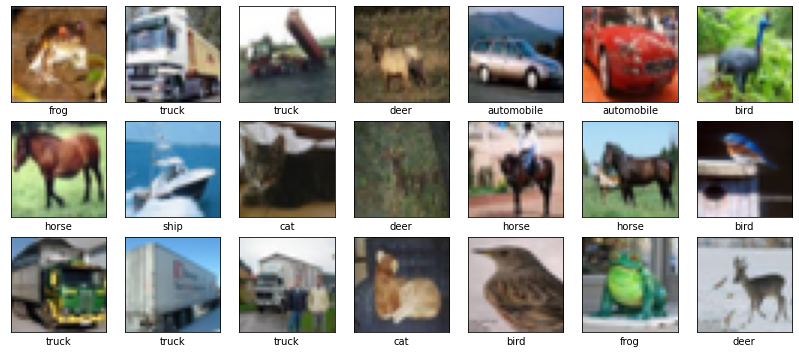

In [10]:
print(x_train.shape, y_train.shape)
visualize_data(x_train, y_train, class_names)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [32, 32, 3], padding = 'same', use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides = strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_201 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_85 (ResidualUn (None, 4, 4, 64)          78592     
_________________________________________________________________
residual_unit_86 (ResidualUn (None, 4, 4, 64)          74240     
_________________________________________________________________
residual_unit_87 (ResidualUn (None, 4, 4, 64)        

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 87s 50ms/step - loss: 0.5850 - accuracy: 0.8011 - val_loss: 0.8648 - val_accuracy: 0.7205
Epoch 2/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.4314 - accuracy: 0.8526 - val_loss: 0.8778 - val_accuracy: 0.7237
Epoch 3/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.3515 - accuracy: 0.8800 - val_loss: 0.9090 - val_accuracy: 0.7075
Epoch 4/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.3656 - accuracy: 0.8732 - val_loss: 0.9101 - val_accuracy: 0.7191
Epoch 5/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.3168 - accuracy: 0.8899 - val_loss: 0.8830 - val_accuracy: 0.7370
Epoch 6/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.2476 - accuracy: 0.9133 - val_loss: 0.9004 - val_accuracy: 0.7382
Epoch 7/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.2462 - accuracy: 0.9174 - val_loss: 0.9317 -

# **Exercise 8:**

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

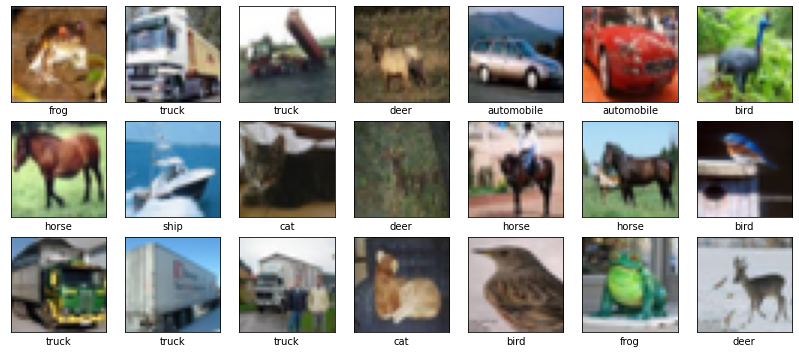

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)
x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

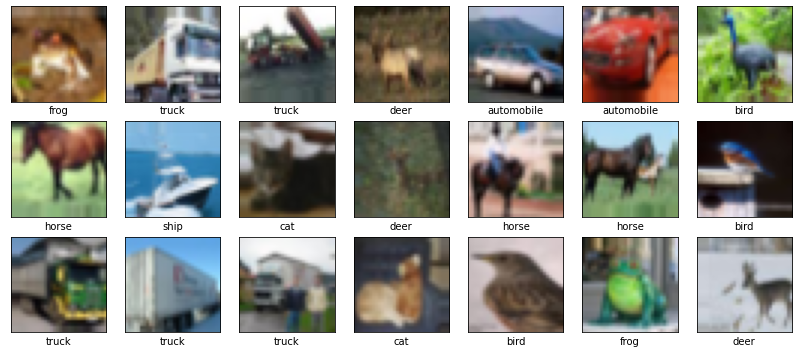

In [12]:
width_shift = 3 / 32
height_shift = 3 / 32
flip = True

datagen = ImageDataGenerator(horizontal_flip = flip, 
                             width_shift_range = width_shift,
                             height_shift_range = height_shift)
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle = False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [13]:
train_datagen = ImageDataGenerator(horizontal_flip = flip, width_shift_range = width_shift,height_shift_range = height_shift)
valid_datagen = ImageDataGenerator(rescale = 1)

train_generator = train_datagen.flow(x_train, y = y_train, batch_size = 32)
valid_generator = valid_datagen.flow(x_test, y = y_test, batch_size = 32)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
history = model.fit(train_generator, epochs = 10, validation_data = valid_generator)
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 94s 55ms/step - loss: 0.7353 - accuracy: 0.7618 - val_loss: 0.7427 - val_accuracy: 0.7513
Epoch 2/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.6949 - accuracy: 0.7671 - val_loss: 1.0454 - val_accuracy: 0.7086
Epoch 3/10
1563/1563 [==============================] - 85s 54ms/step - loss: 0.6269 - accuracy: 0.7835 - val_loss: 1.2315 - val_accuracy: 0.6656
Epoch 4/10
1563/1563 [==============================] - 86s 55ms/step - loss: 0.6699 - accuracy: 0.7689 - val_loss: 0.9511 - val_accuracy: 0.6872
Epoch 5/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.6942 - accuracy: 0.7616 - val_loss: 0.9180 - val_accuracy: 0.7068
Epoch 6/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.6567 - accuracy: 0.7726 - val_loss: 0.8386 - val_accuracy: 0.7457
Epoch 7/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.5983 - accuracy: 0.7934 - val_loss: 1.0455 -

# **Exercise 9:**

In [14]:
class ResidualUnit50(keras.layers.Layer):
  def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [keras.layers.Conv2D(filters, 1, strides = strides, padding = 'same', use_bias = False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters, 3, strides = 1, padding = 'same', use_bias = False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(4 * filters, 1, strides = 1, padding = 'same', use_bias = False),
                        keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [keras.layers.Conv2D(4 * filters, 2, strides = strides, padding = 'same', use_bias = False),
                          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [15]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [32, 32, 3], padding = 'same', use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit50(filters, strides = strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit50 (ResidualUni (None, 4, 4, 256)         125440    
_________________________________________________________________
residual_unit50_1 (ResidualU (None, 4, 4, 256)         71168     
_________________________________________________________________
residual_unit50_2 (ResidualU (None, 4, 4, 256)         7

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
history = model.fit(train_generator, epochs = 20, validation_data = valid_generator)
score = model.evaluate(x_test, y_test)

Epoch 1/20
1563/1563 [==============================] - 181s 87ms/step - loss: 2.4882 - accuracy: 0.2836 - val_loss: 2.4341 - val_accuracy: 0.3818
Epoch 2/20
1563/1563 [==============================] - 136s 87ms/step - loss: 1.9158 - accuracy: 0.3869 - val_loss: 4.5220 - val_accuracy: 0.2965
Epoch 3/20
1563/1563 [==============================] - 136s 87ms/step - loss: 1.8293 - accuracy: 0.3980 - val_loss: 1.8435 - val_accuracy: 0.3121
Epoch 4/20
1563/1563 [==============================] - 137s 88ms/step - loss: 1.8518 - accuracy: 0.3758 - val_loss: 1.8070 - val_accuracy: 0.3713
Epoch 5/20
1563/1563 [==============================] - 138s 88ms/step - loss: 1.6088 - accuracy: 0.4458 - val_loss: 1.3618 - val_accuracy: 0.5199
Epoch 6/20
1563/1563 [==============================] - 138s 88ms/step - loss: 1.4155 - accuracy: 0.5174 - val_loss: 2.1676 - val_accuracy: 0.3339
Epoch 7/20
1563/1563 [==============================] - 138s 88ms/step - loss: 1.3721 - accuracy: 0.5346 - val_loss: 1